<a href="https://colab.research.google.com/github/ramin-nouri/sunram/blob/main/latest%20version.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
import pandas as pd

# Load URLs from the CSV file
csv_file_path = '/content/zurich.csv'
url_df = pd.read_csv(csv_file_path, header=None, names=['url'])
image_urls = url_df['url'].tolist()


In [4]:
import requests
from PIL import Image
from io import BytesIO

def download_and_compress_image(url, target_size=(224, 224), quality=85):
    try:
        response = requests.get(url)
        img = Image.open(BytesIO(response.content))
        img = img.resize(target_size)
        img_byte_arr = BytesIO()
        img.save(img_byte_arr, format='JPEG', quality=quality)
        img_byte_arr = img_byte_arr.getvalue()
        return img_byte_arr
    except Exception as e:
        print(f"Error downloading or compressing {url}: {e}")
        return None

# Download and compress images
compressed_images = [download_and_compress_image(url) for url in image_urls]


/usr/local/lib/python3.10/dist-packages/PIL/Image.py:3167: DecompressionBombWarning: Image size (100000000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


In [5]:
import os

# Directory to save images
save_dir = '/mnt/data/compressed_images'
os.makedirs(save_dir, exist_ok=True)

# Save images to the directory
for idx, img_data in enumerate(compressed_images):
    if img_data is not None:
        file_name = os.path.join(save_dir, f'image_{idx}.jpeg')
        with open(file_name, 'wb') as img_file:
            img_file.write(img_data)


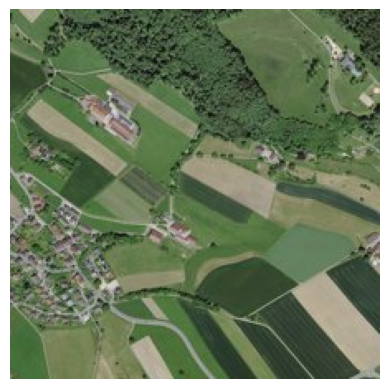

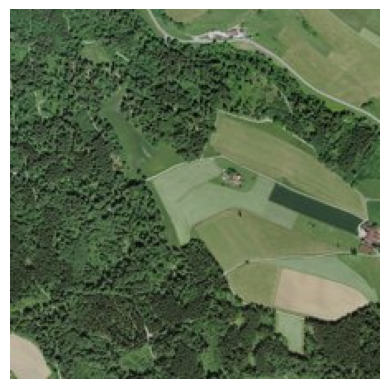

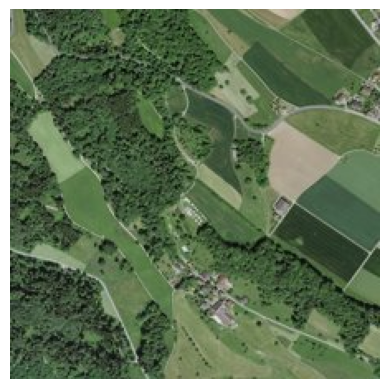

In [6]:
from PIL import Image
import matplotlib.pyplot as plt

# Function to load and display an image
def display_image(image_path):
    img = Image.open(image_path)
    plt.imshow(img)
    plt.axis('off')
    plt.show()

# Display the first few images
for i in range(3):
    display_image(f'/mnt/data/compressed_images/image_{i}.jpeg')


In [7]:
import zipfile
import os

# Path to the ZIP file and the directory where you want to extract it
zip_file_path = '/content/labled.zip'
extraction_directory = '/content/extracted_images'

# Create the extraction directory if it doesn't exist
os.makedirs(extraction_directory, exist_ok=True)

# Extract the ZIP file
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extraction_directory)

print("Extraction Completed.")


Extraction Completed.


In [8]:
# List the first few files in the extraction directory
extracted_files = os.listdir(extraction_directory)
print("Extracted files:", extracted_files[:5])


Extracted files: ['PV01_325358_1205361.bmp', 'PV01_325195_1204153_label.bmp', 'PV01_325213_1204191.bmp', 'PV01_325215_1204189.bmp', 'PV01_325127_1204232_label.bmp']


In [9]:
import os

# Directory containing the extracted images
image_directory = '/content/extracted_images'

# Separating the raw images and their corresponding labels
raw_images = []
label_images = []

for filename in os.listdir(image_directory):
    if filename.endswith('_label.bmp'):
        label_images.append(filename)
    else:
        raw_images.append(filename)

# Just to verify
print("Raw images:", raw_images[:5])
print("Label images:", label_images[:5])


Raw images: ['PV01_325358_1205361.bmp', 'PV01_325213_1204191.bmp', 'PV01_325215_1204189.bmp', 'PV01_325356_1205367.bmp', 'PV01_325122_1203842.bmp']
Label images: ['PV01_325195_1204153_label.bmp', 'PV01_325127_1204232_label.bmp', 'PV01_325322_1205369_label.bmp', 'PV01_325328_1205372_label.bmp', 'PV01_325222_1204202_label.bmp']


In [10]:
import os
from tensorflow.keras.preprocessing.image import img_to_array, load_img

def preprocess_image(image_path, target_size=(224, 224)):
    image = img_to_array(load_img(image_path, target_size=target_size)) / 255.0
    return image

# Assuming extraction_directory is correctly set
preprocessed_images = [preprocess_image(os.path.join(extraction_directory, img)) for img in raw_images]
preprocessed_labels = [preprocess_image(os.path.join(extraction_directory, lbl)) for lbl in label_images]


In [11]:
from sklearn.model_selection import train_test_split

train_images, test_images, train_labels, test_labels = train_test_split(
    preprocessed_images, preprocessed_labels, test_size=0.2, random_state=42)
train_images, val_images, train_labels, val_labels = train_test_split(
    train_images, train_labels, test_size=0.25, random_state=42)


In [12]:
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Dropout, Conv2DTranspose, concatenate
from tensorflow.keras.models import Model

def unet_model(input_size=(224, 224, 3)):
    inputs = Input(input_size)

    # Contracting Path (Downsampling)
    c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(inputs)
    c1 = Dropout(0.1)(c1)
    c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
    p1 = MaxPooling2D((2, 2))(c1)

    c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
    c2 = Dropout(0.1)(c2)
    c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
    p2 = MaxPooling2D((2, 2))(c2)

    c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
    c3 = Dropout(0.2)(c3)
    c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
    p3 = MaxPooling2D((2, 2))(c3)

    c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
    c4 = Dropout(0.2)(c4)
    c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
    p4 = MaxPooling2D(pool_size=(2, 2))(c4)

    # Bottleneck
    c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p4)
    c5 = Dropout(0.3)(c5)
    c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)

    # Expansive Path (Upsampling)
    u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
    u6 = concatenate([u6, c4])
    c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u6)
    c6 = Dropout(0.2)(c6)
    c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)

    u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6)
    u7 = concatenate([u7, c3])
    c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
    c7 = Dropout(0.2)(c7)
    c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)

    u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c7)
    u8 = concatenate([u8, c2])
    c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u8)
    c8 = Dropout(0.1)(c8)
    c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c8)

    u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c8)
    u9 = concatenate([u9, c1], axis=3)
    c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u9)
    c9 = Dropout(0.1)(c9)
    c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c9)

    outputs = Conv2D(1, (1, 1), activation='sigmoid')(c9)

    model = Model(inputs=[inputs], outputs=[outputs])
    return model

# Instantiate and compile the model
model = unet_model()
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


In [13]:
import numpy as np

def preprocess_label(image_path, target_size=(224, 224)):
    image = img_to_array(load_img(image_path, target_size=target_size, color_mode='grayscale')) / 255.0
    return image

preprocessed_labels = np.array([preprocess_label(os.path.join(extraction_directory, f)) for f in label_images])
print("Label shape:", preprocessed_labels.shape)  # This should output (num_samples, 224, 224, 1)


Label shape: (665, 224, 224, 1)


In [14]:

train_images, val_images, train_labels, val_labels = train_test_split(
    preprocessed_images, preprocessed_labels, test_size=0.25, random_state=42)


In [15]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Create image data augmentation generators
data_gen_args = dict(rotation_range=10,
                     width_shift_range=0.1,
                     height_shift_range=0.1,
                     shear_range=0.1,
                     zoom_range=0.1,
                     horizontal_flip=True,
                     fill_mode='nearest')

image_datagen = ImageDataGenerator(**data_gen_args)
mask_datagen = ImageDataGenerator(**data_gen_args)

# Provide the same seed and keyword arguments to the fit methods
seed = 1
image_datagen.fit(train_images, augment=True, seed=seed)
mask_datagen.fit(train_labels, augment=True, seed=seed)


In [16]:
print(f"Number of training images: {len(train_images)}")


Number of training images: 498


In [17]:
batch_size = 32  # Adjust as necessary
steps_per_epoch = max(1, len(train_images) // batch_size)
print(f"Steps per epoch: {steps_per_epoch}")


Steps per epoch: 15


In [18]:
print(f"Number of training images: {len(train_images)}")
print(f"Number of training labels: {len(train_labels)}")


Number of training images: 498
Number of training labels: 498


In [19]:
import numpy as np

train_images = np.array(train_images)
train_labels = np.array(train_labels)

print("Shape of train_images:", train_images.shape)
print("Shape of train_labels:", train_labels.shape)


Shape of train_images: (498, 224, 224, 3)
Shape of train_labels: (498, 224, 224, 1)


In [20]:
batch_size = 5  # or 3
steps_per_epoch = max(1, len(train_images) // batch_size)
print(f"Batch size: {batch_size}, Steps per epoch: {steps_per_epoch}")


Batch size: 5, Steps per epoch: 99


In [21]:
val_images = np.array(val_images)
val_labels = np.array(val_labels)


In [22]:
print(f"Number of validation images: {len(val_images)}")
print(f"Number of validation labels: {len(val_labels)}")


Number of validation images: 167
Number of validation labels: 167


In [23]:
val_images = np.array(val_images)
val_labels = np.array(val_labels)

print("Shape of val_images:", val_images.shape)
print("Shape of val_labels:", val_labels.shape)


Shape of val_images: (167, 224, 224, 3)
Shape of val_labels: (167, 224, 224, 1)


In [24]:
history = model.fit(
    image_datagen.flow(train_images, train_labels, batch_size=batch_size, seed=seed),
    steps_per_epoch=steps_per_epoch,
    epochs=10,  # Adjust as necessary
    validation_data=(val_images, val_labels)
)


Epoch 1/10
99/99 [==============================] - 23s 92ms/step - loss: 0.5849 - accuracy: 0.6903 - val_loss: 0.5451 - val_accuracy: 0.7360
Epoch 2/10
99/99 [==============================] - 5s 52ms/step - loss: 0.5775 - accuracy: 0.6916 - val_loss: 0.5628 - val_accuracy: 0.7360
Epoch 3/10
99/99 [==============================] - 5s 52ms/step - loss: 0.5723 - accuracy: 0.6938 - val_loss: 0.5330 - val_accuracy: 0.7360
Epoch 4/10
99/99 [==============================] - 5s 51ms/step - loss: 0.5718 - accuracy: 0.6907 - val_loss: 0.5301 - val_accuracy: 0.7360
Epoch 5/10
99/99 [==============================] - 5s 52ms/step - loss: 0.5694 - accuracy: 0.6935 - val_loss: 0.5286 - val_accuracy: 0.7360
Epoch 6/10
99/99 [==============================] - 5s 52ms/step - loss: 0.5705 - accuracy: 0.6914 - val_loss: 0.5264 - val_accuracy: 0.7360
Epoch 7/10
99/99 [==============================] - 5s 52ms/step - loss: 0.5696 - accuracy: 0.6900 - val_loss: 0.5421 - val_accuracy: 0.7360
Epoch 8/10
9

In [30]:
test_images = np.array(test_images)
test_labels = np.array(test_labels)

print("Shape of test_images:", test_images.shape)
print("Shape of test_labels:", test_labels.shape)


Shape of test_images: (133, 224, 224, 3)
Shape of test_labels: (133, 224, 224, 3)


In [31]:
# Evaluate the model
test_loss, test_accuracy = model.evaluate(test_images, test_labels)
print(f"Test Loss: {test_loss}, Test Accuracy: {test_accuracy}")


5/5 [==============================] - 0s 18ms/step - loss: 0.5249 - accuracy: 0.7463
Test Loss: 0.5248900651931763, Test Accuracy: 0.746328592300415


In [32]:
model.save('my_model.h5')  # Saves the model for future use


1/1 [==============================] - 0s 25ms/step


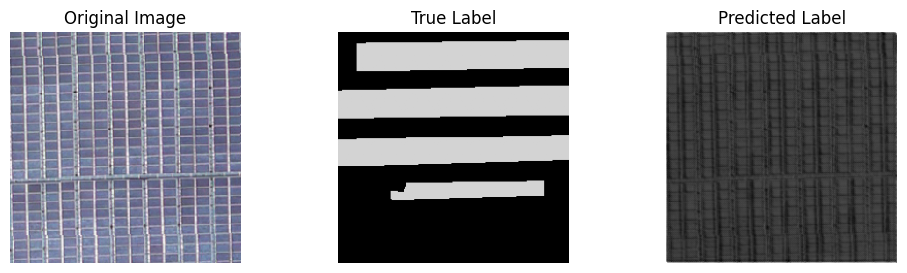

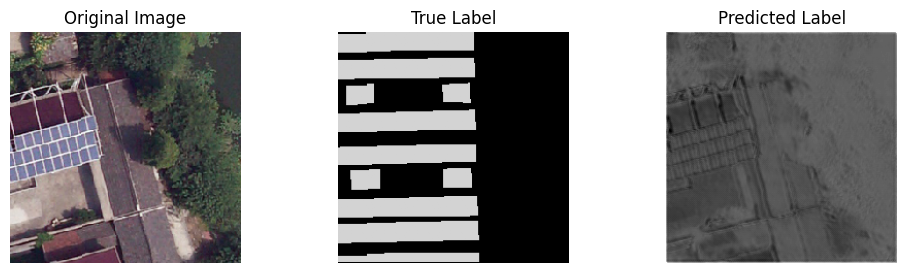

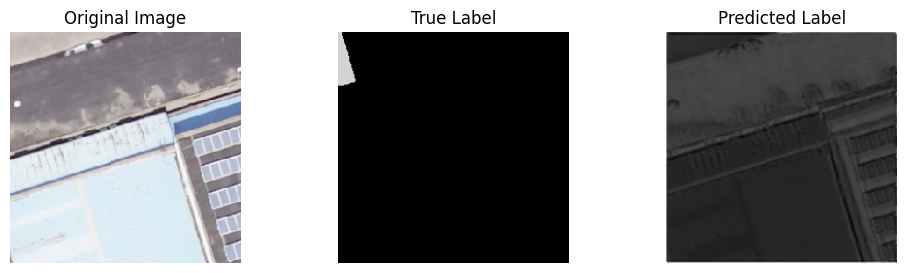

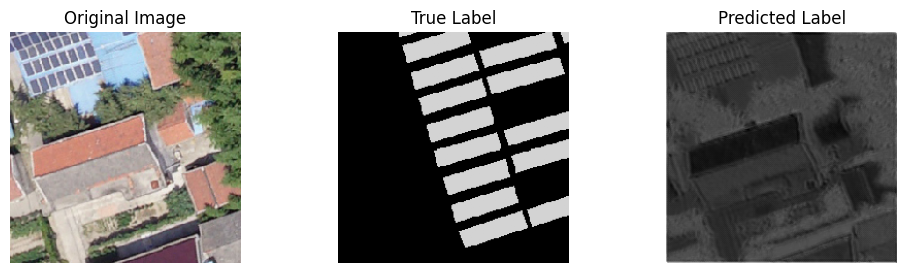

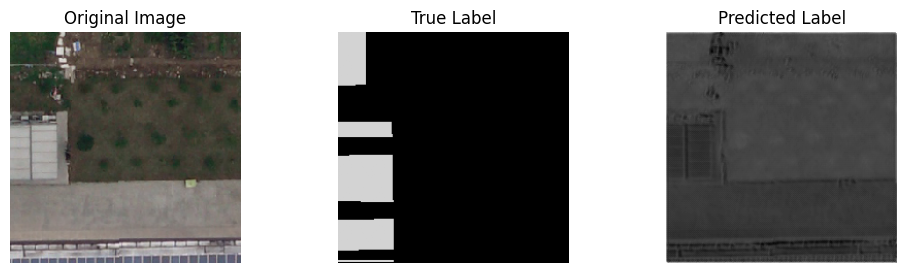

In [33]:
import matplotlib.pyplot as plt

# Select a few images from your test set
test_sample_images = test_images[:5]
test_sample_labels = test_labels[:5]

predicted_labels = model.predict(test_sample_images)

for i in range(len(test_sample_images)):
    plt.figure(figsize=(12, 3))

    # Display original image
    plt.subplot(1, 3, 1)
    plt.imshow(test_sample_images[i])
    plt.title("Original Image")
    plt.axis('off')

    # Display true label (mask)
    plt.subplot(1, 3, 2)
    plt.imshow(test_sample_labels[i].squeeze(), cmap='gray')
    plt.title("True Label")
    plt.axis('off')

    # Display predicted label (mask)
    plt.subplot(1, 3, 3)
    plt.imshow(predicted_labels[i].squeeze(), cmap='gray')
    plt.title("Predicted Label")
    plt.axis('off')

    plt.show()
